In [1]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
from scipy.linalg import eig
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

import moyra as ma
import moyra.elements as ele
import moyra.forces as ef

import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo
import FwtModels as mf

me.mechanics_printing()

In [2]:
b_modes = 1
t_modes = 1
inner_wing_modes = b_modes+t_modes

fwt_modes = 6
modes = inner_wing_modes + fwt_modes

main_panels = 20
fwt_panels = 15
tab_panels = 10
panels = main_panels + fwt_panels

p = ma.DynamicModelParameters(modes)

## Create some global parameters
p.b_modes = ma.ModelSymbol(value = b_modes,string = 'b_modes') # percentage of wing that is a FWT
p.t_modes = ma.ModelSymbol(value = t_modes,string = 't_modes') # percentage of wing that is a FWT

p.c = ma.ModelSymbol(value = 0.15,string = 'c') # chord of wing
p.s_i = ma.ModelSymbol(value = 1,string = 's_i') # total semi-span of wing
p.s_f = ma.ModelSymbol(value = 0.345,string = 's_f') # total semi-span of wingtip
p.s_t = ma.ModelSymbol(value = 0.1,string = 's_t') # total length of the tab
p.alpha_r = ma.ModelSymbol(value = np.deg2rad(3),string = 'alpha_r') # root AoA

## inner beam section
p.c_b = ma.ModelSymbol(value = 0.03,string = 'c_b') # chord of beam
p.rho_b = ma.ModelSymbol(value = 19.53,string = 'rho_b') # beam mass per unit area (kg/m^2)
p.EI = ma.ModelSymbol(value = 9.77e6,string = 'EI') # Bending stiffness for the wing
p.GJ = ma.ModelSymbol(value = 0.99e6,string = 'GJ') # Torsional Stiffness for the wing


## wing uniform mass
p.rho_w = ma.ModelSymbol(value = 19.53,string = 'rho_w') # wing mass per unit area (kg/m^2)
p.c_w = ma.ModelSymbol(value = 0.15,string = 'c_w') # chord over which to integrate wing mass


# Location of flexural axes fro beam
p.e_0 = ma.ModelSymbol(value = 0.08,string = 'e_0')
p.x_f0 = ma.ModelSymbol(value = 0.08,string = 'x_f')

# FWT mass element
p.m_f = ma.ModelSymbol(value = 0.3,string = 'm_f')
p.x_comf = ma.ModelSymbol(value = 0.3,string = 'x_comf')
p.y_comf = ma.ModelSymbol(value = 0.3,string = 'y_comf')
p.I_xxf = ma.ModelSymbol(value = 0.3,string = 'I_xxf') # inertia of FWT (uniform bar)
p.I_yyf = ma.ModelSymbol(value = 0.3,string = 'I_yyf') # inertia of FWT (uniform bar)

# FWT properties
p.Lambda = ma.ModelSymbol(value = np.deg2rad(10),string = 'Lambda') # Flare Angle
p.mu = ma.ModelSymbol(value = 0,string = 'mu')                 # dihedral angle at the end of the inner wing
p.mu_d = ma.ModelSymbol(value = 0,string = 'mu_d') # rate of change of dihedral angle at the tip of the inner wing

# Symbols to translate along inner wing and FWT
p.y_0 =ma.ModelSymbol(value = 0,string = 'y_0')        # inner wing y chord
p.x_0 = ma.ModelSymbol(value = 0,string = 'x_0')       # inner wing x chord
p.y_1 = ma.ModelSymbol(value = 0,string = 'y_1')       # FWT y chord
p.x_1 = ma.ModelSymbol(value = 0,string = 'x_1')       # FWT x chord

# Unsteady Aero Terms
p.k = ma.ModelSymbol(value = 0,string = 'k')    # reduced frequency
p.AR = ma.ModelSymbol(value = 0,string = 'AR')    # Aspect Ratio
p.M_thetadot = ma.ModelSymbol(value = -1.2,string = 'M_thetadot')    # Unsteady Torsional Term

## Aero Parameters
p.rho = ma.ModelSymbol(value = 1.225,string = 'rho')                 # density
p.V = ma.ModelSymbol(value = 10,string = 'V')                        # velocity
p.c_dmax = ma.ModelSymbol(value = 0.01,string = 'c_dmax')             # c_dmax
p.x_l = ma.ModelSymbol(value = 0.25,string = 'x_l')    # location of lift as percentage of the chord

# C_L curve terms
p.alpha_max = ma.ModelSymbol(value = np.deg2rad(15),string = 'alpha_max')# peak AoA
p.clip_factor = ma.ModelSymbol(value = 0.1,string = 'clip_factor')    # clipping factor for stall
p.stall_factor = ma.ModelSymbol(value = 0.1,string = 'stall_factor')    # clipping factor for stall
p.stall_rate = ma.ModelSymbol(value = np.deg2rad(0.5),string = 'stall_rate')    # clipping factor for stall
p.a_i = ma.ModelSymbol(value = 2*np.pi,string = 'a_i')               # C_L slope of main wing
p.a_0i = ma.ModelSymbol(value = 2*np.pi,string = 'a_0i')               # C_L slope of main wing
p.a = ma.ModelMatrix(value =[np.pi*2]*panels,length=panels, string='a') # local C_l

# gravity terms
p.g  = ma.ModelSymbol(value = 9.81,string = 'g')                     # gravity
p.g_v = ma.ModelMatrix(value =[0,0,-1],length=3,string='g_v')      # gravity unit vector


## FWT tab Wing Specific
p.beta_t = ma.ModelSymbol(value = 0,string = 'beta_t')               # tab
p.beta_m = ma.ModelSymbol(value = 0,string = 'beta_m')               # tab
p.beta_a = ma.ModelSymbol(value = 0,string = 'beta_a')               # tab

## FWT Aero Specific
p.alpha_1 = ma.ModelSymbol(value = 0,string = 'alpha_1')             # FWT alpha
p.alphadot_1 = ma.ModelSymbol(value = 0,string = 'alphadot_1')       # FWT alphadot

## Numeric Model Constants
p.fp = ma.ModelMatrix(value =[0]*p.qs*2,length=p.qs*2,string='fp') # The stationary point

# Factor to change the size of joint values
p.eta = ma.ModelMatrix(value = [1]*modes,length=modes,string='eta')

In [3]:
#get shape functions for main wing
z_0,tau_0 = ele.FlexiElement.ShapeFunctions_BN_TM(b_modes,t_modes,p.q[:inner_wing_modes],p.y_0,p.x_0,0,0,factor=p.eta,type='taylor')
# apply weighting function
#define wrefernce frames
wing_root_frame = ma.HomogenousTransform()

wing_frame = wing_root_frame.Translate(p.x_0,p.y_0,z_0)
wing_flexural_frame = wing_root_frame.Translate(0,p.y_0,z_0.subs({p.x_0:0}))

# hinge_frame
tip_twist = tau_0.subs({p.y_0:p.s_i})
hinge_frame = wing_flexural_frame.subs({p.y_0:p.s_i}).R_y(tip_twist).R_z(p.Lambda).simplify()

# FWT_frame
fwt_frame = ma.HomogenousTransform().Translate(*p.q[inner_wing_modes:inner_wing_modes+3]).R_y(p.q[inner_wing_modes+3]).R_z(p.q[inner_wing_modes+4]).R_x(p.q[inner_wing_modes+5])
# fwt_frame = ma.HomogenousTransform().Translate(*p.q[inner_wing_modes:inner_wing_modes+3]).R_euler_params(p.q[inner_wing_modes+3:inner_wing_modes+fwt_modes])

fwt_hinge_frame = fwt_frame.Translate(-p.x_comf+p.x_f0,-p.y_comf,0).R_z(p.Lambda)

In [4]:
#Create Elemnts
M_wing = ele.MassMatrix(p.rho_w)
M_beam = ele.MassMatrix(p.rho_b)
M_fwt = ele.MassMatrix(p.m_f,I_xx = p.I_xxf,I_yy = p.I_yyf)

## inner beam element
beam_x_int = (p.x_0,-p.c_b/2,p.c_b/2)
beam_y_int = (p.y_0,0,p.s_i)
beam_mass_ele = ele.FlexiElement(wing_frame,M_beam,p.x_0,p.y_0,beam_x_int,beam_y_int,0,p.EI,p.GJ,gravityPot=True)

## wing mass element inner
wing_x_int = (p.x_0,-p.x_f0,p.c_w-p.x_f0)
wing_y_int = (p.y_0,0,p.s_i)
wing_mass_ele = ele.FlexiElement(wing_frame,M_wing,p.x_0,p.y_0,wing_x_int,wing_y_int,0,0,0,gravityPot=True)

## FWT mass element
x_com = (p.x_comf-p.x_f0)
y_com = (p.y_comf + x_com*sym.tan(p.Lambda))*sym.cos(p.Lambda)
fwt_ele = ele.RigidElement(fwt_frame,M_fwt,True)

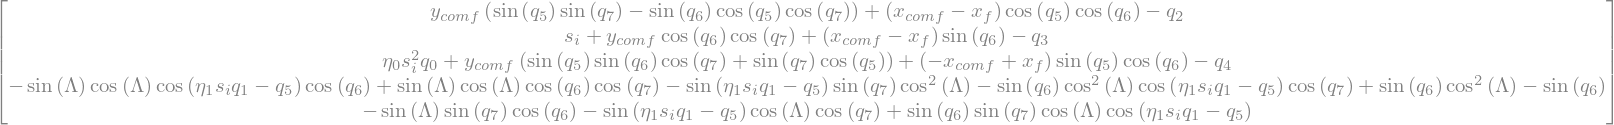

In [5]:
C =[]
xyz = sym.simplify(hinge_frame.Transform_point([0,0,0])-fwt_hinge_frame.Transform_point([0,0,0]))
ydot = sym.simplify(hinge_frame.Transform_vector([1,0,0]).T*fwt_hinge_frame.Transform_vector([0,1,0]))
zdot = sym.simplify(hinge_frame.Transform_vector([1,0,0]).T*fwt_hinge_frame.Transform_vector([0,0,1]))
C = sym.BlockMatrix([[xyz],[ydot],[zdot]]).as_explicit()
C

In [6]:
%%timeit -n 1 -r 1
sm = ma.SymbolicModel.FromElementsAndForces(p,[wing_mass_ele,beam_mass_ele,fwt_ele],C=C)

0
1
2
32.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [7]:
%%timeit -n 1 -r 1
sm2 = ma.SymbolicModel.FromElementsAndForcesSimple(p,[wing_mass_ele,beam_mass_ele,fwt_ele],C=C)

0
1
2
54.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [7]:
fold_angle = sym.simplify(hinge_frame.Transform_vector([0,0,1]).T*fwt_hinge_frame.Transform_vector([0,0,1]))[0]
fold_angle

In [8]:
base_dir = "C:\\Git\\NastranMBD\\"
class_name = "B3T2_FWT"
base_class = "BaseMBD"
sm.to_matlab_class(p,base_dir,class_name,base_class,additional_funcs=[('get_fold_angle',fold_angle)])

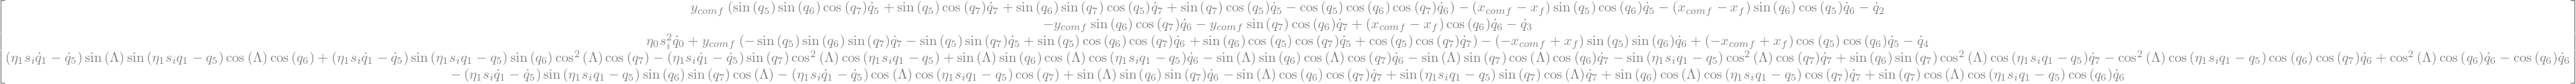

In [9]:
C.diff(me.dynamicsymbols._t,1)